In [50]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

## Assigning to GPU

In [51]:
# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [52]:
# Load the dataset
df = pd.read_csv(r"C:\Users\HP\Downloads\Housing-1 - Housing-1.csv")

In [53]:
# Display first few rows
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [54]:
df.nunique()

price               219
area                284
bedrooms              6
bathrooms             4
stories               4
mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
parking               4
prefarea              2
furnishingstatus      3
dtype: int64

## Check total count of items and notna and compare
If they are the same then no need to drop na 

In [55]:
df.count()

price               545
area                545
bedrooms            545
bathrooms           545
stories             545
mainroad            545
guestroom           545
basement            545
hotwaterheating     545
airconditioning     545
parking             545
prefarea            545
furnishingstatus    545
dtype: int64

In [56]:
df.notna().sum()

price               545
area                545
bedrooms            545
bathrooms           545
stories             545
mainroad            545
guestroom           545
basement            545
hotwaterheating     545
airconditioning     545
parking             545
prefarea            545
furnishingstatus    545
dtype: int64

# Data Preprocessing: Binary Conversion and One-Hot Encoding

In this code snippet, we perform two important preprocessing steps to prepare the dataset for machine learning modeling:

1. **Binary Conversion**:
   - We convert binary categorical features from 'yes'/'no' values to numerical representations (1 for 'yes' and 0 for 'no').
   - The features involved in this conversion include:
     - `mainroad`
     - `guestroom`
     - `basement`
     - `hotwaterheating`
     - `airconditioning`
     - `prefarea`
   - This transformation is done using the `applymap` function with a lambda expression.

2. **One-Hot Encoding**:
   - The `furnishingstatus` feature has multiple categories, such as 'furnished', 'semi-furnished', and 'unfurnished'.
   - One-hot encoding is applied to convert this categorical feature into multiple binary columns, which allows machine learning algorithms to effectively interpret the data.
   - By setting `drop_first=True`, we avoid multicollinearity by dropping one of the categories.

These preprocessing steps ensure that the categorical variables are in a numerical format suitable for machine learning models.


In [57]:
df_cleaned=df
# Convert binary categorical features ('yes'/'no') to 0/1
binary_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df_cleaned[binary_features] = df_cleaned[binary_features].applymap(lambda x: 1 if x == 'yes' else 0)
# One-hot encode the 'furnishingstatus' categorical feature
df_cleaned = pd.get_dummies(df_cleaned, columns=['furnishingstatus'], drop_first=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_18264\542503029.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned[binary_features] = df_cleaned[binary_features].applymap(lambda x: 1 if x == 'yes' else 0)


# Min-Max Scaling for Continuous and Ordinal Features

In this code snippet, we apply Min-Max scaling to the continuous and ordinal features of our dataset:

1. **Min-Max Scaling**:
   - Min-Max scaling transforms features by scaling them to a specified range, typically \([0, 1]\).
   - This scaling technique is particularly useful for continuous and ordinal features, as it ensures that all features contribute equally to distance calculations in machine learning algorithms.

2. **Implementation**:
   - We create an instance of `MinMaxScaler`.
   - The features to be scaled are specified by combining the lists of `continuous_features` and `ordinal_features`.
   - We use the `fit_transform` method to fit the scaler to the data and transform it in one step.

By applying Min-Max scaling, we ensure that our dataset is normalized, which can improve the performance and convergence speed of various machine learning algorithms.


In [59]:
# Define continuous and ordinal features
continuous_features = ['area', 'price']
ordinal_features = ['bedrooms', 'bathrooms', 'stories', 'parking']

In [60]:
# Apply Min-Max scaling to continuous and ordinal features
# Min-Max scaling transforms features by scaling them to a given range, typically [0, 1].
# This is useful for continuous and ordinal features, as it ensures that they contribute equally to the distance calculations in algorithms.
# The features to be scaled are specified in the list combining 'continuous_features' and 'ordinal_features'.
scaler = MinMaxScaler()
df_cleaned[continuous_features + ordinal_features] = scaler.fit_transform(df_cleaned[continuous_features + ordinal_features])

In [61]:
df_cleaned.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,1.000000,0.396564,0.6,0.333333,0.666667,1,0,0,0,1,0.666667,1,False,False
1,0.909091,0.502405,0.6,1.000000,1.000000,1,0,0,0,1,1.000000,0,False,False
2,0.909091,0.571134,0.4,0.333333,0.333333,1,0,1,0,0,0.666667,1,True,False
3,0.906061,0.402062,0.6,0.333333,0.333333,1,0,1,0,1,1.000000,1,False,False
4,0.836364,0.396564,0.6,0.000000,0.333333,1,1,1,0,1,0.666667,0,False,False


In [62]:
df_cleaned.count()

price                              545
area                               545
bedrooms                           545
bathrooms                          545
stories                            545
mainroad                           545
guestroom                          545
basement                           545
hotwaterheating                    545
airconditioning                    545
parking                            545
prefarea                           545
furnishingstatus_semi-furnished    545
furnishingstatus_unfurnished       545
dtype: int64

In [63]:
df_cleaned.dtypes

price                              float64
area                               float64
bedrooms                           float64
bathrooms                          float64
stories                            float64
mainroad                             int64
guestroom                            int64
basement                             int64
hotwaterheating                      int64
airconditioning                      int64
parking                            float64
prefarea                             int64
furnishingstatus_semi-furnished       bool
furnishingstatus_unfurnished          bool
dtype: object

In [64]:
# Convert boolean columns to integers (0 and 1)
df_cleaned['furnishingstatus_semi-furnished'] = df_cleaned['furnishingstatus_semi-furnished'].astype(int)
df_cleaned['furnishingstatus_unfurnished'] = df_cleaned['furnishingstatus_unfurnished'].astype(int)

In [65]:
df_cleaned.dtypes

price                              float64
area                               float64
bedrooms                           float64
bathrooms                          float64
stories                            float64
mainroad                             int64
guestroom                            int64
basement                             int64
hotwaterheating                      int64
airconditioning                      int64
parking                            float64
prefarea                             int64
furnishingstatus_semi-furnished      int32
furnishingstatus_unfurnished         int32
dtype: object

# Preparing Features (X) and Target Variable (y)

In this code snippet, we prepare the feature set \(X\) and the target variable \(y\) from the cleaned DataFrame:




In [66]:
# Prepare the features (X) and target (y)
# The feature set (X) is created by dropping the 'price' column from the cleaned DataFrame.
# This includes all columns except 'price', which are used as input features for the model.
X = df_cleaned.drop('price', axis=1).values  # All features except 'price'

# The target variable (y) is the 'price' column, which we want to predict.
# We use the reshape method to convert the target into a 2D array with one column,
# which is often required for compatibility with certain machine learning models.
y = df_cleaned['price'].values.reshape(-1, 1)  # Target is 'price'

In [67]:
# Train-test split: 80% train + val, 20% test
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.4, random_state=42)

# Train-validation split: 80% train, 20% validation
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.2, random_state=42)


In [68]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Implementing a neural network for regression

In [69]:
# Neural network model
class HousingModel(nn.Module):
    def __init__(self):
        super(HousingModel, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)  # Increased the size of first hidden layer
        self.dropout1 = nn.Dropout(p=0.3)      # Dropout with 30% probability
        
        self.fc2 = nn.Linear(128, 64)          # Second hidden layer
        self.dropout2 = nn.Dropout(p=0.3)

        self.fc3 = nn.Linear(64, 32)           # Third hidden layer
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.fc4 = nn.Linear(32, 1)            # Output layer (single value for regression)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)

        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

# Training and Validation Function for Model Evaluation

This code snippet defines a function, `train_validate_model`, which is responsible for training a machine learning model and validating its performance. The function tracks the Mean Squared Error (MSE) and Mean Absolute Error (MAE) during training and validation phases. Below are the key components and steps involved:


In [70]:
# Function for training, validating, and tracking MSE and MAE
def train_validate_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    # Lists to store training and validation losses and metrics
    train_losses = []
    val_losses = []
    train_mae_list = []
    val_mae_list = []
    train_mse_list = []
    val_mse_list = []
    
    best_val_loss = float('inf')  # Initialize best validation loss

    for epoch in range(epochs):  # Loop through each epoch
        model.train()  # Set model to training mode
        running_train_loss = 0.0  # Initialize training loss
        y_train_true = []  # List to store true training targets
        y_train_pred = []  # List to store predicted training outputs
        
        # Training loop
        for inputs, targets in train_loader:  # Iterate over training data
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Calculate loss
            loss.backward()  # Backward pass to compute gradients
            optimizer.step()  # Update model weights
            running_train_loss += loss.item()  # Accumulate training loss
            y_train_true.extend(targets.cpu().numpy())  # Store true targets
            y_train_pred.extend(outputs.cpu().detach().numpy())  # Store predictions

        # Calculate metrics for training
        avg_train_loss = running_train_loss / len(train_loader)  # Average training loss
        train_mae = mean_absolute_error(y_train_true, y_train_pred)  # Mean Absolute Error
        train_mse = mean_squared_error(y_train_true, y_train_pred)  # Mean Squared Error

        # Append metrics for visualization later
        train_losses.append(avg_train_loss)
        train_mae_list.append(train_mae)
        train_mse_list.append(train_mse)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0  # Initialize validation loss
        y_val_true = []  # List to store true validation targets
        y_val_pred = []  # List to store predicted validation outputs
        with torch.no_grad():  # Disable gradient calculation for validation
            for inputs, targets in val_loader:  # Iterate over validation data
                inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)  # Calculate loss
                running_val_loss += loss.item()  # Accumulate validation loss
                y_val_true.extend(targets.cpu().numpy())  # Store true targets
                y_val_pred.extend(outputs.cpu().detach().numpy())  # Store predictions

        # Calculate metrics for validation
        avg_val_loss = running_val_loss / len(val_loader)  # Average validation loss
        val_mae = mean_absolute_error(y_val_true, y_val_pred)  # Mean Absolute Error
        val_mse = mean_squared_error(y_val_true, y_val_pred)  # Mean Squared Error

        # Append metrics for visualization later
        val_losses.append(avg_val_loss)
        val_mae_list.append(val_mae)
        val_mse_list.append(val_mse)

        # Save best model based on validation loss
        if avg_val_loss < best_val_loss:  # Check if current validation loss is better
            best_val_loss = avg_val_loss  # Update best validation loss
            torch.save(model.state_dict(), "best_model.pth")  # Save the model's state dictionary

        # Step the learning rate scheduler
        scheduler.step()

        # Print metrics for the current epoch
        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Train Loss: {avg_train_loss:.4f}, Train MAE: {train_mae:.4f}, Train MSE: {train_mse:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val MAE: {val_mae:.4f}, Val MSE: {val_mse:.4f}")
    print(f"Best model saved at val_loss:  {best_val_loss:.4f}")  # Indicate best model saved
    return train_losses, val_losses, train_mae_list, val_mae_list, train_mse_list, val_mse_list

        

In [71]:
# Define parameters and instantiate model
epochs=500
model = HousingModel().to(device)
criterion = nn.MSELoss()  # Use MSE for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [72]:
# Create DataLoader for training, validation, and testing
# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [73]:
# Assuming train_loader and val_loader are defined DataLoaders
train_losses, val_losses, train_mae_list, val_mae_list, train_mse_list, val_mse_list=train_validate_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device,epochs)

Epoch 1/500 - Train Loss: 0.0429, Train MAE: 0.1622, Train MSE: 0.0443, Val Loss: 0.0260, Val MAE: 0.1244, Val MSE: 0.0263
Epoch 2/500 - Train Loss: 0.0275, Train MAE: 0.1305, Train MSE: 0.0273, Val Loss: 0.0286, Val MAE: 0.1177, Val MSE: 0.0289
Epoch 3/500 - Train Loss: 0.0214, Train MAE: 0.0972, Train MSE: 0.0186, Val Loss: 0.0263, Val MAE: 0.1124, Val MSE: 0.0266
Epoch 4/500 - Train Loss: 0.0178, Train MAE: 0.1027, Train MSE: 0.0179, Val Loss: 0.0210, Val MAE: 0.1030, Val MSE: 0.0212
Epoch 5/500 - Train Loss: 0.0169, Train MAE: 0.0904, Train MSE: 0.0161, Val Loss: 0.0207, Val MAE: 0.1009, Val MSE: 0.0209
Epoch 6/500 - Train Loss: 0.0129, Train MAE: 0.0848, Train MSE: 0.0132, Val Loss: 0.0195, Val MAE: 0.0978, Val MSE: 0.0197
Epoch 7/500 - Train Loss: 0.0144, Train MAE: 0.0885, Train MSE: 0.0144, Val Loss: 0.0208, Val MAE: 0.1006, Val MSE: 0.0210
Epoch 8/500 - Train Loss: 0.0135, Train MAE: 0.0842, Train MSE: 0.0136, Val Loss: 0.0187, Val MAE: 0.0960, Val MSE: 0.0188
Epoch 9/500 - Tr

# Function for plotting MSE and MAE

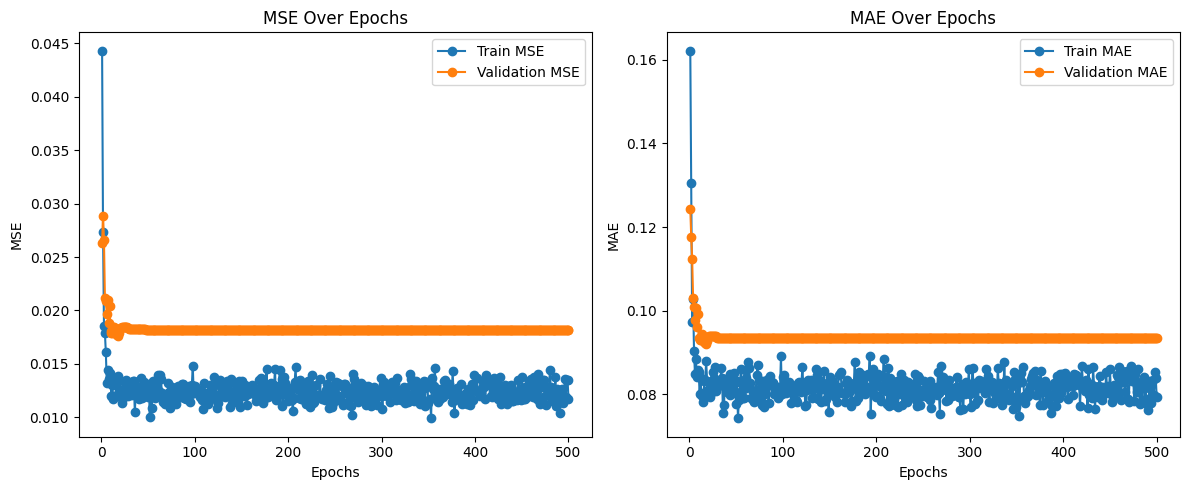

In [74]:
# Function to plot MSE and MAE
def plot_metrics(train_losses, val_losses, train_mae, val_mae, train_mse, val_mse):
    epochs = len(train_losses)
    x_axis = np.arange(1, epochs + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot for MSE
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, train_mse, label='Train MSE', marker='o')
    plt.plot(x_axis, val_mse, label='Validation MSE', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('MSE Over Epochs')
    plt.legend()

    # Plot for MAE
    plt.subplot(1, 2, 2)
    plt.plot(x_axis, train_mae, label='Train MAE', marker='o')
    plt.plot(x_axis, val_mae, label='Validation MAE', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('MAE Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()
# After training, plot the metrics
plot_metrics(train_losses, val_losses, train_mae_list, val_mae_list, train_mse_list, val_mse_list)

# Model Testing Function

The `test_model` function is designed to evaluate the performance of a trained machine learning model on a test dataset. It calculates the average test loss and the Root Mean Squared Error (RMSE) as key metrics to assess how well the model generalizes to unseen data. Below are the key components and steps involved in the function:

In [75]:
# Function for testing the model
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0  # Initialize variable to accumulate test loss
    y_test_true = []  # List to store true target values
    y_test_pred = []  # List to store predicted values

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, targets in test_loader:  # Iterate over test data
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device

            # Forward pass to get model predictions
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Calculate the loss

            running_test_loss += loss.item()  # Accumulate test loss
            y_test_true.extend(targets.cpu().numpy())  # Store true target values
            y_test_pred.extend(outputs.cpu().detach().numpy())  # Store predicted values

    # Calculate average test loss by dividing the total loss by the number of batches
    avg_test_loss = running_test_loss / len(test_loader)

    # Calculate test Root Mean Squared Error (RMSE) to evaluate prediction accuracy
    test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))

    # Print the test loss and RMSE for evaluation
    print(f"Test Loss: {avg_test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

    # Return the true target values and the model's predictions as numpy arrays
    return np.array(y_test_true), np.array(y_test_pred)

In [76]:
# Call the test_model function and get predictions
y_test_true, y_test_pred = test_model(model, test_loader, criterion, device)

Test Loss: 0.0177, Test RMSE: 0.1332


# Visualization of Predictions

The `visualize_predictions` function is designed to visualize the relationship between the actual target values and the predicted values generated by the model. This visualization helps assess how well the model is performing. Below are the key components and steps involved in the function:


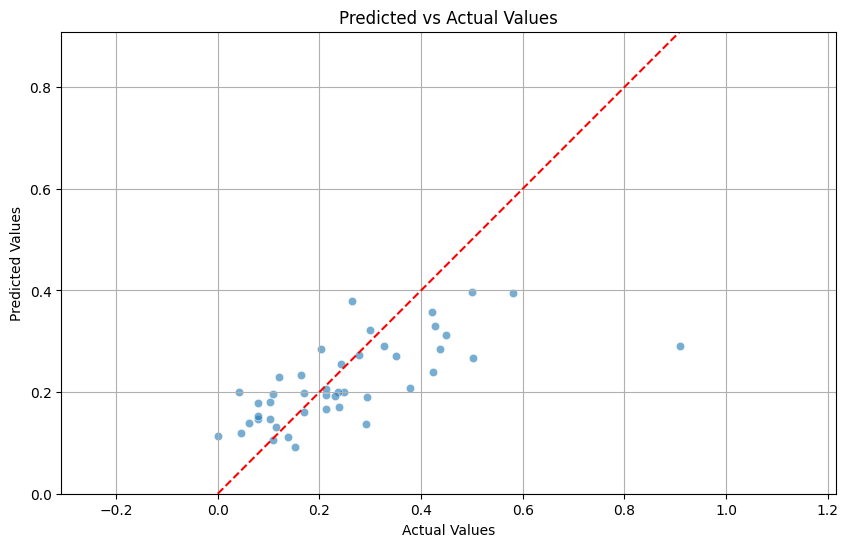

In [77]:
def visualize_predictions(y_true, y_pred):
    # Create a new figure for the plot with specified size
    plt.figure(figsize=(10, 6))

    # Scatter plot of actual vs predicted values
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='w', linewidth=0.5)
    
    # Determine the maximum and minimum values from true and predicted values for the line of perfect predictions
    max_val = max(max(y_true), max(y_pred))
    min_val = min(min(y_true), min(y_pred))
    
    # Plotting a line for perfect predictions (y = x) to visually compare predictions
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    # Adding labels and title to the plot
    plt.xlabel('Actual Values')  # Label for the x-axis
    plt.ylabel('Predicted Values')  # Label for the y-axis
    plt.title('Predicted vs Actual Values')  # Title for the plot
    plt.grid(True)  # Enable grid for better readability
    plt.axis('equal')  # Equal scaling for x and y axes
    plt.xlim(min_val, max_val)  # Set x-axis limits
    plt.ylim(min_val, max_val)  # Set y-axis limits
    
    # Show the plot
    plt.show()

# Call the function after testing your model to visualize the results
visualize_predictions(y_test_true, y_test_pred)
